In [17]:
import xarray as xr
import numpy as np
from geomedian import geometric_median #import the geomedian module
from cosdistance import Cosdistance #import the cosine distance module
from datetime import datetime, timedelta
from loaddea import loaddea
from severitymapping import severitymapping
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [34]:
# get the data from the datacube
locationname = 'MtDavidStateForest' #define the name of the location and used in the filename
latmin = -33.96 #define the study area with top left and bottom right corner latitude and longitude
latmax = -33.67
lonmin = 149.36
lonmax = 149.71
startdate = datetime(2005,1,1) #define the starting and ending period
stopdate = datetime(2006,12,31)
landsat_numbers = [5] # the number of landsat sensor, it can be single sensor or multiple ones e.g.[5,8]

In [ ]:
# load the data for the selected region and period use the loaddea module, quality pixel mask has been applied
data = loaddea(latmin,latmax,lonmin,lonmax,startdate,stopdate,landsat_numbers) 

In [ ]:
#calculate the Geomatric Median for the whole period and the cosine distance relative to the geomatric median
def Geomatric_Median_Cosdist(data):
    MaxInter = 60
    tol      = 1.e-7
    Nbands = 6
    GeoMed= np.empty((Nbands,len(data.y),len(data.x)))
    GeoMed.fill(np.nan)
    cosdist = np.empty((len(data.time),len(data.y),len(data.x)))
    #for x in range(0,len(data.x)):
    for y in range(0,len(data.y)):
        X = np.empty((Nbands,len(data.time),len(data.x)))
        X[0,:,:] = data.blue[:,y,:] 
        X[1,:,:] = data.green[:,y,:]
        X[2,:,:] = data.red[:,y,:]
        X[3,:,:] = data.nir[:,y,:]
        X[4,:,:] = data.swir1[:,y,:]
        X[5,:,:] = data.swir2[:,y,:]
        X[X<=0] = np.nan
        GeoMed[:,y,:] = np.transpose(np.vstack([geometric_median(X[:,:,x],tol,MaxInter) for x in range(0,len(data.x))])) #calculate geomatric median
        #Euc = [Eucdistance(GeoMed[:,y,x],X[:,:,x]) for x in range(0,len(data.x))] # Euclidean distance can also be calculated
        Cos = [Cosdistance(GeoMed[:,y,x],X[:,:,x]) for x in range(0,len(data.x))]
        #Eucdist[:,y,:]=np.transpose(np.vstack(Euc))
        cosdist[:,y,:]=np.transpose(np.vstack(Cos)) #cosine distance
    
    return GeoMed, cosdist

In [ ]:
# calculate the Geomatric Median for the given period and cosine distance
GeoMed,cosdist = Geomatric_Median_Cosdist(data)

In [ ]:
#save Gemetric median and cosine distance to netcdf
filename = locationname+'_GMandDist_'+startdate.strftime("%Y")+'_'+stopdate.strftime("%Y")+'_landsat'+str(landsat_numbers[0])+'.nc'
ds = xr.Dataset({'blue':(('y','x'),GeoMed[0,:,:]),'green':(('y','x'),GeoMed[1,:,:]),'red':(('y','x'),GeoMed[2,:,:]),\
               'nir':(('y','x'),GeoMed[3,:,:]),'swir1':(('y','x'),GeoMed[4,:,:]),'swir2':(('y','x'),GeoMed[5,:,:]),\
                'CosDist':(('time','y','x'),cosdist[:])},\
               coords={'time':data.time[:],'y':data.y[:],'x':data.x[:]},attrs={'geospatial_bounds_crs':'EPSG:4326','lat_min':latmin,\
                                                        'lat_max':latmax,'lon_min':lonmin,\
                                                        'lon_max':lonmax})

ds.time.attrs=[]
ds.to_netcdf('/g/data/xc0/project/Burn_Mapping/Geometric_Median/'+filename,'w')

In [7]:
#Severity mapping and duration of change
severity,startdates,duration = severitymapping(cosdist,ds.time)

Text(0.5,1,'Severity')

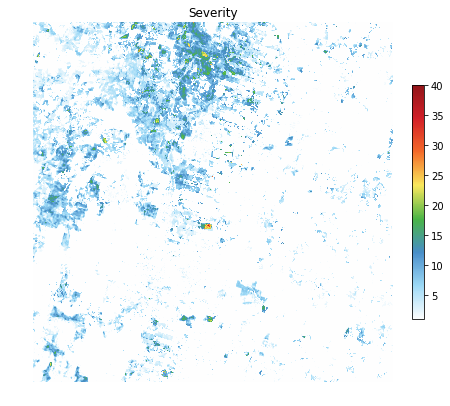

In [13]:
#plot the severity map or duration
import pandas as pd
colors = pd.read_fwf('mycolormap.txt',header=None)
import matplotlib as mpl
mycolormap = np.zeros((len(colors),3))
mycolormap[:,0]=colors[0]
mycolormap[:,1]=colors[1]
mycolormap[:,2]=colors[2]
cmap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
          mycolormap/256)

plt.figure(figsize=(7,7))
im=plt.imshow(severity[:,:],cmap=cmap,vmin=1,vmax=40)
plt.colorbar(im,fraction=0.03, pad=0.05)
plt.axis('off')
plt.title('Severity')

In [14]:
# save the severity results in netcdf if needed
outputfile = '/g/data/xc0/project/Burn_Mapping/SeverityMapping/'+locationname+'_Severity_'+startdate.strftime("%Y")+'_'+stopdate.strftime("%Y")+'_landsat'+str(landsat_numbers[0])+'.nc'
ds2 = xr.Dataset({'Severity':(('y','x'),severity[:,:]),\
                 'Duration':(('y','x'),duration[:,:])},coords={'y':data.y[:],'x':data.x[:]})
ds2.to_netcdf(outputfilename)

AttributeError: 'numpy.ndarray' object has no attribute 'strftime'